# Variance reduction in MLDA

MLDA is based on the idea of running multiple chains which sample from approximations of the true posterior (where the approximation normally become coarser when going from the top level to the bottom level). Due to this characteristic, MLDA draws MCMC samples from all those levels. These samples, apart from improving the mixing of the top-level chain can serve another purpose; we can use them to apply a variance reduction technique when estimating a quantity of interest from the drawn samples.

#### Typical quantity of interest estimation in MCMC
Specifically, here we are interested in cases where we have a a forward model $F$ which is a function of an unknown vector of random variables $\theta$, i.e. $F = F(\theta)$. $F$ is a model of some physical process or phenomenon and $\theta$ is usually a set of unknown parameters in the model. We want to estimate a quantity of interest $Q$ which depends on the forward model $F$, i.e. $Q = Q(F(\theta))$. In order to do that, we draw samples from the posterior of $P(\theta | D)$, where $D$ are our data, and we use the samples to construct an estimator $E_P[Q] = {1\over N} \Sigma_{n}Q(F(\theta_n))$ where $\theta_n$ is the $n-th$ sample drawn from the posterior $P$ using MCMC.

In the context of groundwater flow modelling (which is used in this notebook), the quantity of interest $Q$ could, for example, be the value of the pressure or the Darcy flux at or around a given point in the computational domain, or the outflow over parts of the boundary.

#### Quantity of interest estimation using variance reduction in MLDA
In usual MCMC algorithm we would sample from the posterior and use the samples to get the estimate above. In MLDA, we have the extra advantage that we do not only draw samples from the correct/fine posterior $P$ but we also draw samples from approximation of it. We can use those samples to reduce the variance of the estimator of $Q$ (and thus require fewer samples to achieve the same variance). 

The technique we use is similar to the idea of a telescopic sum. Instead of estimating $Q$ directly, we estimate differences of $Q$ estimates between levels and add those differences (i.e. we estimate the correction with respect to the next lower level). 

Specifically, we have a set of approximate forward models $F_l$ and posteriors $P_l, l \in \{0,1,...,L-1\}$, where $L$ is the number of levels in MLDA, $F_{L-1} = F$ and $P_{L-1} = P$. MLDA in level $l$ produces the samples $\theta_{1:N_l}^l$ from posterior $P_l$, where $N_l$ is the number of samples at that level (each level generates a different number of samples, with $N_l$ strictly decreasing with $l$). This also results in the quantities of interest $Q_l = Q(F_l(\theta))$ for each level $l$. We use the following equation to estimate the quanity of interest:
$E_{VR}[Q] = E_{P_0}[Q_0] + \Sigma_{l=1}^{L-1} (E_{P_l}[Q_l] - E_{P_{l-1}}[Q_{l-1}])$. 

The first term in the right hand side can be estimated using the samples from level 0. For the second term in the right hand side which contains all the differences, we estimate using the following process: In level $l$, and for each sample $\theta_n^l$ in that level where $n \in {1,...,N_l}$, we take the samples $\theta_{s:(s+K)}^{l-1}$ from level $l-1$, which is the block of $K$ samples generated in level $l$ to propose a sample for level $l$, where $s$ is the starting sample. In other words $K$ is the subsampling rate at level $l$. We randomly pick one of those $K$ samples, say with index $k$. We calculate the following quantity: $Y_n^l = Q_l(F_l(\theta_n^l)) - Q_{l-1}(F_{l-1}(\theta_k^{l-1}))$. We do the same thing for all $N_l$ samples in level $l$ and finally use them to calculate $E_{P_l}[Q_l] - E_{P_{l-1}}[Q_{l-1}] = {1 \over N_l} \Sigma Y_n^l$. We do the same to estimate the remaining differences and add them all together to get $E_VR[Q]$.

The latter estimate is shown to have asymptotically lower variance than $E_P[Q]$ in [1].

#### Using variance reductioon in PyMC3
The code in this notebook demonstrates how the user can employ the variance reduction technique within the PyMC3 implementation of MLDA. We run two samplers, one with VR and one without and calculate the resulting variances in the estimates.

In order to use variance reduction, the user needs to pass the argument `variance_reduction=True` when instantiating the MLDA stepper. Also, they need to do two things when defining the PyMC3 model: 
- Include a `pm.Data()` variable with the name `Q` in the model description as shown in the code.
- Use a theano Op to describe the forward model (or the combination of a forward model and a likelihood). This Op should have a `perform()` method which (in addition to all the other calculations), calculates the quantity of interest and stores it to the variable `Q` of the PyMC3 model, using the `set_value()` function. An example is shown below.

By doing the above, the user provides MLDA with the quantity of interest in each MCMC step. MLDA then internally stores and manages the values and returns all the terms necessary to calculate $E_{VR}[Q]$ (i.e. all $Q_0$ values and all $Y_n^l$ differences/corrections) within the stats of the generated trace. The user can extract them using the `get_sampler_stats()` function of the trace object, as shown at the end of the notebook.


### Dependencies
The code has been developed and tested with Python 3.6. You will need to have pymc3 installed and also [FEniCS](https://fenicsproject.org/) for your system. FEniCS is a popular, open-source, [well documented](https://fenicsproject.org/documentation/), high-performance computing framework for solving Partial Differential Equations. FEniCS can be [installed](https://fenicsproject.org/download/) either through their prebuilt Docker images, from their Ubuntu PPA, or from Anaconda. 
  

### References
[1] Dodwell, Tim & Ketelsen, Chris & Scheichl, Robert & Teckentrup, Aretha. (2019). Multilevel Markov Chain Monte Carlo. SIAM Review. 61. 509-545. https://doi.org/10.1137/19M126966X


### Import modules

In [1]:
# Import groundwater flow model utils
import sys
sys.path.insert(1, 'mlda/')

In [2]:
import os
import numpy as np
import time
import pymc3 as pm
import theano.tensor as tt
from Model import Model, model_wrapper, project_eigenpairs
from itertools import product
import matplotlib.pyplot as plt
os.environ['OPENBLAS_NUM_THREADS'] = '1'  # Set environmental variable
%matplotlib inline

### Set parameters

In [3]:
# Set the resolution of the multi-level models (from coarsest to finest)
# This is a list of different model resolutions. Each
# resolution added to the list will add one level to the multi-level
# inference. Each element is a tuple (x,y) where x, y are the number of 
# points in each dimension. For example, here we set resolutions = 
# [(30, 30), (120, 120)] which creates a coarse, cheap 30x30 model and 
# a fine, expensive 120x120 model.
resolutions = [(20, 20), (30, 30), (60, 60)]

# Set random field parameters
field_mean = 0
field_stdev = 1
lamb_cov = 0.1

# Set the number of unknown parameters (i.e. dimension of theta in posterior)
nparam = 2

# Number of draws from the distribution
ndraws = 2000

# Number of burn-in samples
nburn = 2000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100
discard_tuning = True

# Number of independent chains
nchains = 1

# Subsampling rate for MLDA
nsub = 5

# variance reduction
vr = True

# Do blocked/compounds sampling in Metropolis and MLDA
# Note: This choice applies only to the coarsest level in MLDA
# (where a Metropolis sampler is used), all other levels use block sampling
blocked = False

# Set the sigma for inference
sigma = 0.01

# Data generation seed
data_seed = 12345

# Sampling seed
sampling_seed = 12345

# Datapoints list
points_list = [0.1, 0.3, 0.5, 0.7, 0.9]

### Define the quantity of interest
First we need to define a function that calculates the quantity of interest $Q$ given the model.
This can be any quantity dependent on the unknown variable $\theta$ or the output of the forward model.
In this case, the quantity of interest is the hydraulic head at some fixed point (x, y)=(0.5, 0.45).
It needs to run after solving model PDE. The code for the solver is imported from an external file.

In [4]:
def quantity_of_interest(my_model):
    """Quantity of interest function"""
    return my_model.solver.h(0.5, 0.45)

### Define the forward model
In order to use variance reduction, the user needs to define a Theano Op that calculates the forward model 
(or both the forward model and the likelihood).
Also, this Op needs to save the quantity of interest to a model variable with the name Q.
Here we use a Theano Op along with the code within ./mlda to construct the forward model.

In [5]:
class ForwardModel(tt.Op):
    """
    Theano Op that wraps the forward model computation,
    necessary to pass "black-box" fenics code into pymc3.
    Based on the work in:
    https://docs.pymc.io/notebooks/blackbox_external_likelihood.html
    https://docs.pymc.io/Advanced_usage_of_Theano_in_PyMC3.html
    """

    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model) and returning a a vector of model outputs
    itypes = [tt.dvector]  # expects a vector of parameter values (theta)
    otypes = [tt.dvector]  # outputs a vector of model outputs

    def __init__(self, my_model, x, pymc3_model):
        """
        Initialise the Op with various things that our forward model function
        requires.
        Parameters
        ----------
        my_model:
            A Model object (defined in file model.py) that contains the parameters
            and functions of our model.
        x:
            The dependent variable (aka 'x') that our model requires. This is
            the datapoints in this example.
        """
        # add inputs as class attributes
        self.my_model = my_model
        self.x = x
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs[0]  # this will contain my variables

        # call the forward model function - this solves the model PDE
        outputs[0][0] = model_wrapper(self.my_model, theta, self.x)

        # call the quantity of interest function after the model has been solved
        # with the provided theta
        # save the result inside the pymc3 model variable 'Q'
        # Note that the result needs to be saved to 'Q' in order to do variance reduction
        self.pymc3_model.Q.set_value(quantity_of_interest(self.my_model))

### Instantiate Model objects and data

In [6]:
# Note this can take several minutes for large resolutions
my_models = []
for r in resolutions:
    my_models.append(Model(r, field_mean, field_stdev, nparam, lamb_cov))

# Project eignevactors from fine model to all coarse models
for i in range(len(my_models[:-1])):
    project_eigenpairs(my_models[-1], my_models[i])



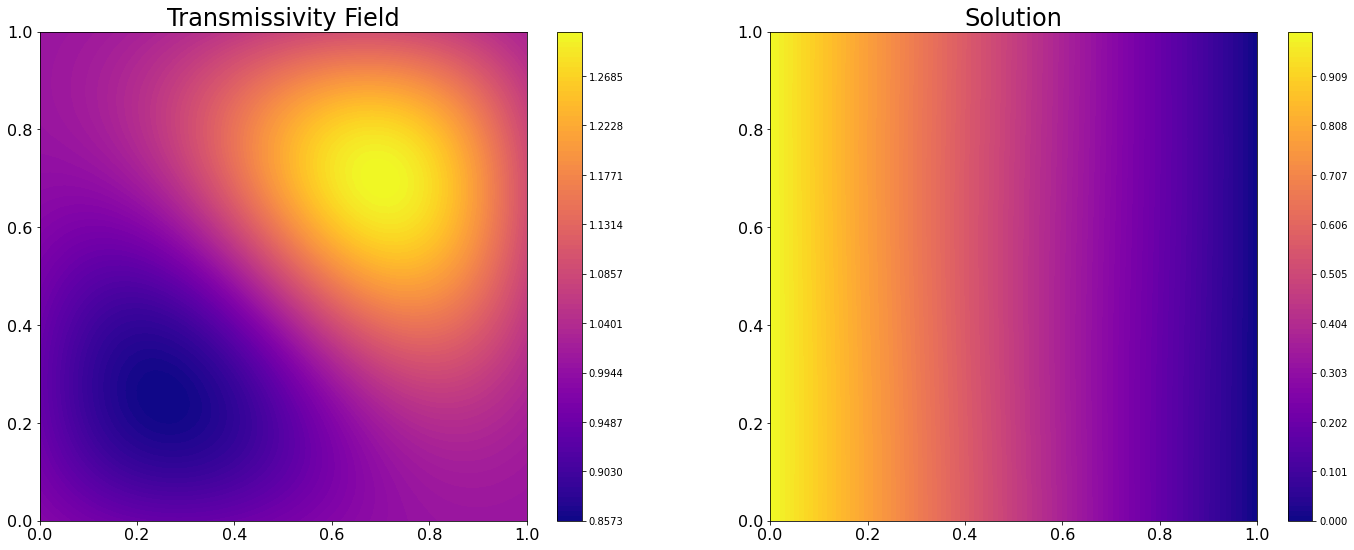

In [7]:
# Solve finest model as a test and plot transmissivity field and solution
np.random.seed(data_seed)
my_models[-1].solve()
my_models[-1].plot(lognormal=False)

# Save true parameters of finest model
true_parameters = my_models[-1].random_process.parameters

In [8]:
# Define the sampling points.
x_data = y_data = np.array(points_list)
datapoints = np.array(list(product(x_data, y_data)))

# Get data from the sampling points and perturb it with some noise.
noise = np.random.normal(0, 0.001, len(datapoints))

# Generate data from the finest model for use in pymc3 inference - these data are used in all levels
data = model_wrapper(my_models[-1], true_parameters, datapoints) + noise

print("True Q: " + str(quantity_of_interest(my_models[-1])))

# Create covariance matrix of normal error - it is a diagonal matrix
s = np.identity(len(data))
np.fill_diagonal(s, sigma ** 2)

True Q: 0.46267383206339147


### Instantiate forward model objects

In [9]:
# create Theano Ops to wrap FM of all model levels and store them in list
mout = []

### Construct pymc3 model objects for coarse models
Here we create the coarse models for MLDA. 
We need to include a `pm.Data()` variable `Q` in each one of those models, instantiated at `0.0`. These variables are set during sampling when the Op code under `perform()` runs.

In [10]:
# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
for j in range(len(my_models) - 1):
    with pm.Model() as model:
        # A variable Q has to be defined if you want to use the variance reduction feature
        # Q can be of any dimension - here it a scalar
        Q = pm.Data('Q', np.float64(0.0))

        # Sigma_e is the covariance of the assumed error 'e' in the model.
        # This error is due to measurement noise/bias vs. the real world
        Sigma_e = pm.Data('Sigma_e', s)

        # uniform priors on unknown parameters
        parameters = []
        for i in range(nparam):
            parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

        # convert thetas to a tensor vector
        theta = tt.as_tensor_variable(parameters)

        # this is a deterministic variable that captures the output of
        # the forward model every time it is run
        mout.append(ForwardModel(my_models[j], datapoints, model))
        output = pm.Potential('output', mout[j](theta))

        # The distribution of the error 'e' (assumed error of the forward model)
        # This is multi-variate normal.
        # This creates the likelihood of the model given the observed data
        pm.MvNormal('e', mu=output, cov=Sigma_e, observed=data)

    coarse_models.append(model)

### Perform inference
Here we define the fine (i.e. correct) model and sample from it using MLDA (with and without variance reduction).
Note that `Q` is use here too.

In [11]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.
method_names = []
traces = []
runtimes = []
acc = []
ess = []
ess_n = []
performances = []

with pm.Model() as fine_model:
    # A variable Q has to be defined if you want to use the variance reduction feature
    # Q can be of any dimension - here it a scalar
    Q = pm.Data('Q', np.float64(0.0))

    # Sigma_e is the covariance of the assumed error 'e' in the model.
    # This error is due to measurement noise/bias vs. the real world
    Sigma_e = pm.Data('Sigma_e', s)

    # uniform priors on unknown parameters
    parameters = []
    for i in range(nparam):
        parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable(parameters)

    # this is a deterministic variable that captures the output of
    # the fine forward model every time it is run
    mout.append(ForwardModel(my_models[-1], datapoints, fine_model))
    output = pm.Potential('output', mout[-1](theta))

    # The distribution of the error 'e' (assumed error of the forward model)
    pm.MvNormal('e', mu=output, cov=Sigma_e, observed=data)

    # Initialise two MLDA step method objects, one without variance reduction but with
    # store_Q_fine set to True and the other with variance reduction.
    # store_Q_fine allows to store the quantities of interest only for the fine chain
    # which permits calculating the standard estimate for comparison with VR
    step_mlda_without = pm.MLDA(subsampling_rates=nsub, coarse_models=coarse_models,
                                tune=tune, tune_interval=tune_interval, base_blocked=blocked,
                                store_Q_fine=True)
    step_mlda_with = pm.MLDA(subsampling_rates=nsub, coarse_models=coarse_models,
                             tune=tune, tune_interval=tune_interval, base_blocked=blocked,
                             variance_reduction=vr,
                             store_Q_fine=True)

    # MLDA with variance reduction
    t_start = time.time()
    method_names.append("MLDA_with_vr")
    traces.append(pm.sample(draws=ndraws, step=step_mlda_with,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed, cores=1))
    runtimes.append(time.time() - t_start)

    # MLDA without variance reduction
    '''
    t_start = time.time()
    method_names.append("MLDA_without_vr")
    traces.append(pm.sample(draws=ndraws, step=step_mlda_without,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed, cores=1))
    runtimes.append(time.time() - t_start)
    '''


/Users/gmingas/projects/pymc3/pymc3/step_methods/metropolis.py:1096: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '
/Users/gmingas/projects/pymc3/pymc3/step_methods/metropolis.py:1096: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '
Sequential sampling (1 chains in 1 job)
MLDA: [theta_1, theta_0]


### Print performance metrics

In [12]:
for i, trace in enumerate(traces):
    acc.append(trace.get_sampler_stats('accepted').mean())
    ess.append(np.array(pm.ess(trace).to_array()))
    ess_n.append(ess[i] / len(trace) / trace.nchains)
    performances.append(ess[i] / runtimes[i])
    print(f'\nSampler {method_names[i]}: {len(trace)} drawn samples in each of '
          f'{trace.nchains} chains.'
          f'\nRuntime: {runtimes[i]} seconds'
          f'\nAcceptance rate: {acc[i]}'
          f'\nESS list: {ess[i]}'
          f'\nNormalised ESS list: {ess_n[i]}'
          f'\nESS/sec: {performances[i]}')


/Users/gmingas/opt/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,



Sampler MLDA_with_vr: 2000 drawn samples in each of 1 chains.
Runtime: 584.7135360240936 seconds
Acceptance rate: 0.9835
ESS list: [1652.59607186 1810.25959669]
Normalised ESS list: [0.82629804 0.9051298 ]
ESS/sec: [2.82633456 3.09597689]


### Show stats summary

In [13]:
# Print true theta values and pymc3 sampling summary
print(f"\nDetailed summaries and plots:\nTrue parameters: {true_parameters}")
for i, trace in enumerate(traces):
    print(f"\nSampler {method_names[i]}:\n", pm.stats.summary(trace))


Detailed summaries and plots:
True parameters: [-0.20470766  0.47894334]


/Users/gmingas/opt/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)



Sampler MLDA_with_vr:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta_0 -0.182  0.163  -0.499    0.111      0.004    0.003    1680.0  1680.0   
theta_1  0.471  0.044   0.385    0.551      0.001    0.001    1812.0  1812.0   

         ess_bulk  ess_tail  r_hat  
theta_0    1653.0    1812.0    NaN  
theta_1    1810.0    1710.0    NaN  


### Show traceplots

/Users/gmingas/opt/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


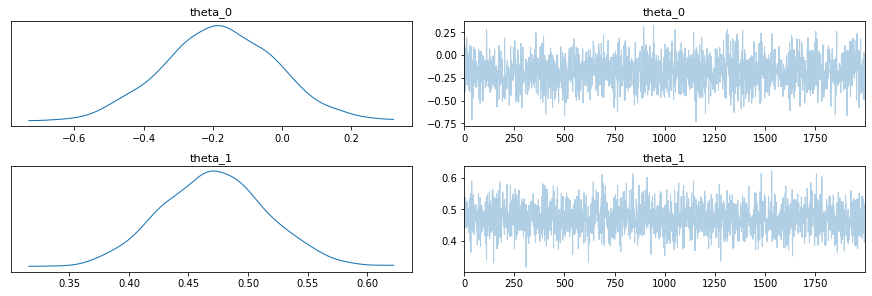

In [14]:
# Print true theta values and pymc3 sampling summary
for i, trace in enumerate(traces):
    pm.plots.traceplot(trace)

### Estimate variances of two methods
Compare variance of Q estimation between:
- Standard approach: Using only Q values from the fine chain (Q_2)
- Telescopic sum-like (VR) approach: Using Q values from the coarsest chain (Q_0), plus all estimates of differences between levels (e.g. Q_1_0, Q_2_1, etc)

In [52]:
Q_2 = traces[0].get_sampler_stats("Q_2").reshape((nchains, ndraws))
Q_0 = np.concatenate(traces[0].get_sampler_stats("Q_0")).reshape((nchains, ndraws * nsub * nsub))
Q_1_0 = np.concatenate(traces[0].get_sampler_stats("Q_1_0")).reshape((nchains, ndraws * nsub))
Q_2_1 = np.concatenate(traces[0].get_sampler_stats("Q_2_1")).reshape((nchains, ndraws))
Q_mean_standard = Q_2.mean(axis=1).mean()
Q_var_standard = Q_2.mean(axis=1).var()
Q_mean_vr = (Q_0.mean(axis=1) + Q_1_0.mean(axis=1) + Q_2_1.mean(axis=1)).mean()
Q_var_vr = (Q_0.mean(axis=1) + Q_1_0.mean(axis=1) + Q_2_1.mean(axis=1)).var()

print(f"Standard method:    Mean: {Q_mean_standard}    Variance: {Q_var_standard}")
print(f"Variance reduction method:    Mean: {Q_mean_vr}    Variance: {Q_var_vr}")

Standard method:    Mean: 0.4633051988899987    Variance: 0.0
Variance reduction method:    Mean: 0.46329108313716033    Variance: 0.0


#### Variances of full samples - it is already visible that Q_2_1 has large variance - larger than Q_2

In [53]:
Q_2.var()

1.183632537065959e-05

In [54]:
Q_0.var()

1.1701873627935067e-05

In [55]:
Q_1_0.var()

9.122623080363085e-06

In [56]:
Q_2_1.var()

1.7516837228668764e-05

#### Calculate standard error of each term using ESS

In [57]:
import arviz
ess_Q2 = arviz.ess(np.array(Q_2[0],np.float64))
ess_Q0 = arviz.ess(np.array(Q_0,np.float64))
ess_Q_1_0 = arviz.ess(np.array(Q_1_0,np.float64))
ess_Q_2_1 = arviz.ess(np.array(Q_2_1,np.float64))

In [58]:
Q_2.var()/ess_Q2

6.542373589402484e-09

In [59]:
Q_0.var()/ess_Q0

1.7262223241340498e-09

In [60]:
Q_1_0.var()/ess_Q_1_0

7.77998859630497e-10

In [61]:
Q_2_1.var()/ess_Q_2_1

9.131633390589718e-09

#### Calculate standard errors of final estimates with either method and with different chunks of the sample
VR always has larger standard error
Notice that the case with 1000 samples gives veryu similar SE to the original run I did here
(where no ESS was used but SE was calculated based on 20 independent runs) : https://github.com/alan-turing-institute/pymc3/blob/feature/variance-reduction/docs/source/notebooks/MLDA_variance_reduction.ipynb

In [73]:
Q2_SE = Q_2[0,0:200].var() / arviz.ess(np.array(Q_2[0,0:200],np.float64))
Q0_SE = Q_0[0,0:5000].var() / arviz.ess(np.array(Q_0[0,0:5000],np.float64))
Q_1_0_SE = Q_1_0[0,0:1000].var() / arviz.ess(np.array(Q_1_0[0,0:1000],np.float64))
Q_2_1_SE = Q_2_1[0,0:200].var() / arviz.ess(np.array(Q_2_1[0,0:200],np.float64))
print("200 samples:")
print("Standard method SE: " + str(Q2_SE))
print("VR method SE: " + str(Q0_SE + Q_1_0_SE + Q_2_1_SE))

200 samples:
Standard method SE: 6.300635795023498e-08
VR method SE: 1.0794449125789527e-07


In [74]:
Q2_SE = Q_2[0,0:1000].var() / arviz.ess(np.array(Q_2[0,0:1000],np.float64))
Q0_SE = Q_0[0,0:25000].var() / arviz.ess(np.array(Q_0[0,0:25000],np.float64))
Q_1_0_SE = Q_1_0[0,0:5000].var() / arviz.ess(np.array(Q_1_0[0,0:5000],np.float64))
Q_2_1_SE = Q_2_1[0,0:1000].var() / arviz.ess(np.array(Q_2_1[0,0:1000],np.float64))
print("1000 samples:")
print("Standard method SE: " + str(Q2_SE))
print("VR method SE: " + str(Q0_SE + Q_1_0_SE + Q_2_1_SE))

1000 samples:
Standard method SE: 1.3009337568139422e-08
VR method SE: 2.0835690651619147e-08


In [64]:
Q2_SE = Q_2.var() / arviz.ess(np.array(Q_2[0],np.float64))
Q0_SE = Q_0.var() / arviz.ess(np.array(Q_0,np.float64))
Q_1_0_SE = Q_1_0.var() / arviz.ess(np.array(Q_1_0,np.float64))
Q_2_1_SE = Q_2_1.var() / arviz.ess(np.array(Q_2_1,np.float64))
print("2000 samples:")
print("Standard method SE: " + str(Q2_SE))
print("VR method SE: " + str(Q0_SE + Q_1_0_SE + Q_2_1_SE))

2000 samples:
Standard method SE: 6.542373589402484e-09
VR method SE: 1.1635854574354265e-08
